# Predicting phase behavior

This notebook will focus on using molecular dynamics (MD) simulation to predict the phase behavior of point particles that interact via the Lennard-Jones potential. 

To perform these simulations we will use HOOMD-Blue, as we can easily and quickly run this from the jupyter notebook.

## Single component Lennard-Jones system

First, let us consider a single component system composed of Lennard-Jones (LJ) spheres, identical to what we have previously examined in prior notebooks.  Here, the goal is to use simulation to perform simulations of the LJ particles in different phases: solid, liquid and gas. 

We will do this by modifying the density and temperature of the simulation to move to different points in the phase diagram. 

The follow paper provides a clear phase diagram that we can use to direct our simulations:
>T. E. Karakasidis, A. Fragkou, and A. Liakopoulos, "System dynamics revealed by recurrence quantification analysis: Application to molecular dynamics simulations" Phys. Rev. E 76, 021120 – Published 24 August 2007
https://journals.aps.org/pre/abstract/10.1103/PhysRevE.76.021120




In [1]:
from IPython.display import Image
Image(url='img/lj_phase_diagram.png')  

### Radial Distribution Function 
A common way to help evaluate the phase of a system is to use the radial distribution function (RDF, sometimes referred to as g(r)). In the RDF, we create a histogram of the distance between all particle pairs, normalized by the density of the system multipied by the volume of the bin (i.e., $\rho *4 \pi r^2dr$ where $\rho$ is the number density and dr is the width of the bin). Systems where particle positions are strongly correlated will show larger values in the RDF. An example of the RDF for different phases is shown below.  See [this link](https://chem.libretexts.org/Bookshelves/Biological_Chemistry/Concepts_in_Biophysical_Chemistry_(Tokmakoff)/01%3A_Water_and_Aqueous_Solutions/01%3A_Fluids/1.02%3A_Radial_Distribution_Function) for more info on the RDF.



In [2]:
from IPython.display import Image
Image(url='https://upload.wikimedia.org/wikipedia/commons/b/b8/Simulated_Radial_Distribution_Functions_for_Solid%2C_Liquid%2C_and_Gaseous_Argon.svg')

### Simulation workflow

We'll need to modify the prior simulation script to allow us to change the box volume, in order to be able to adjust the system density.  A tutorial for modifying the box that provides step-by-step details is available in the (HOOMD-Blue documentation)[https://hoomd-blue.readthedocs.io/en/v3.2.0/tutorial/01-Introducing-Molecular-Dynamics/03-Compressing-the-System.html]. 


The structure of the script is also now slightly changed compared to the prior examples. In the simulation runtime section, we will now have 3 distinct stages:
1) compression  -- adjust the box to achieve the target density
2) relaxation -- allow the system to reach steady state, especially important after the box size perturbation
3) production -- final portion of the simulation for data collection

It is generally good practice to break up a simulation up in sub steps.  This can help to avoid accidentically utilizing non-equilibrium data when reporting properties. This can also make it more obvious if there is an issue, at what point during the simulation workflow is this occuring.    This may often be required to ensure stability, allowing each substep to use different init parameters (e.g., temperature, timestep, integration algorithm, etc.)  For example, the initial configuration may not be especially favorable, with individual particles experiencing large forces; to relieve the system of these high energy/large forces we often use a much smaller timestep initially after performing energy minimization.  Additionally, it is often common practice to start a simulation at higher temperature than the desired target temperature, to help decorrelation from the initial configuration and speed the process of reaching equilibrium (as temperature increases, so does system mobility).

#### Simulation outputs
This simulation run will generate several GSD files. 
* thermo_full.gsd -- thermodynamic quantities logged during the entire duration of the simulation
* thermo_prod.gsd -- thermodynamic quantities logged during the final production portion of the simulation
* trajectory_full.gsd -- trajectory logged during the entire duration of the simulation
* trajectory_prod.gsd -- trajectory logged during the final production portion of the simulation

We will also print to the screen the current timestep and timesteps-per-second periodically during the simulation run, with print statements also noting when each of the substeps have been completed.

We've also made it easier to modify by placing variables for the variables we will be adjust at the top of the script file. 

In [6]:
import hoomd
import gsd.hoomd

system_temperature = 1.0
final_rho = 0.5
compression_time = 20000
relax_time = 50000
production_time = 50000



cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=1)

#########################
# system initialization
#########################

sim.create_state_from_gsd(filename='datafiles/lj.gsd')
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=system_temperature)


#########################
# interaction definition
#########################

cell = hoomd.md.nlist.Cell(buffer=1.0)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('LJ', 'LJ')] = dict(epsilon=1, sigma=1)
lj.r_cut[('LJ', 'LJ')] = 2.5

#########################
# integrator setup
#########################


nvt = hoomd.md.methods.NVT(kT=system_temperature, filter=hoomd.filter.All(), tau=1.0)
integrator = hoomd.md.Integrator(dt=0.005)
integrator.forces.append(lj)
integrator.methods.append(nvt)
sim.operations.integrator = integrator

#########################
# runtime parameters
#########################

# add a logger to output the current step and timesteps per second (TPS) 
logger = hoomd.logging.Logger(categories=['scalar', 'string'])
logger.add(sim, quantities=['timestep', 'tps'])
table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=5000),
                          logger=logger)
sim.operations.writers.append(table)

# add a logger to output the thermodynamic data during the entire run 
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)

log_thermo_full = hoomd.logging.Logger()
log_thermo_full.add(thermodynamic_properties)
gsd_thermo_full = hoomd.write.GSD(filename='thermo_full.gsd',
                             trigger=hoomd.trigger.Periodic(100),
                             mode='wb',
                             filter=hoomd.filter.Null(),
                             log=log_thermo_full)
sim.operations.writers.append(gsd_thermo_full)


log_traj_full = hoomd.logging.Logger()
gsd_traj_full = hoomd.write.GSD(filename='trajectory_full.gsd',
                             trigger=hoomd.trigger.Periodic(5000),
                             mode='wb',
                             filter=hoomd.filter.All(),
                             log=log_traj_full)
sim.operations.writers.append(gsd_traj_full)

# ================
# compress the box
# ================


# ramp will define a switching factor for adjusting from the initial to the final box size
ramp = hoomd.variant.Ramp(A=0, B=1, t_start=sim.timestep, t_ramp=compression_time)

initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box
final_box.volume = sim.state.N_particles / final_rho
box_resize_trigger = hoomd.trigger.Periodic(10)
box_resize = hoomd.update.BoxResize(box1=initial_box,
                                    box2=final_box,
                                    variant=ramp,
                                    trigger=box_resize_trigger)
sim.operations.updaters.append(box_resize)
sim.run(compression_time+1)
if sim.state.box == final_box:
    print("system box size matches target")
    
sim.operations.updaters.remove(box_resize)
print("compression complete")

# ================
# relaxation
# ================

sim.run(relax_time)
print("relaxation complete")

# ================
# production 
# ================

log_thermo = hoomd.logging.Logger()
log_thermo.add(thermodynamic_properties)
gsd_thermo = hoomd.write.GSD(filename='thermo_prod.gsd',
                             trigger=hoomd.trigger.Periodic(100),
                             mode='wb',
                             filter=hoomd.filter.Null(),
                             log=log_thermo)
sim.operations.writers.append(gsd_thermo)

log_traj = hoomd.logging.Logger()
gsd_traj = hoomd.write.GSD(filename='trajectory_prod.gsd',
                             trigger=hoomd.trigger.Periodic(5000),
                             mode='wb',
                             filter=hoomd.filter.All(),
                             log=log_traj)
sim.operations.writers.append(gsd_traj)

sim.run(production_time)

hoomd.write.GSD.write(state=sim.state, filename='final.gsd', mode='wb')
print("simulation complete")

#delete the instances we defined ensure writers are closed
del sim, gsd_thermo, gsd_traj, thermodynamic_properties, log_thermo, log_traj
del log_thermo_full, gsd_thermo_full, logger, table, log_traj_full, gsd_traj_full
del integrator, nvt, lj, cell, cpu

Simulation.timestep  Simulation.tps 
       5000            4032.31336   
       10000           4006.98086   
       15000           4028.91882   
       20000           3933.23395   
       25000           3828.76115   
       30000           3690.47678   
       35000           3571.24745   
       40000           3457.93417   
       45000           3343.86252   
       50000           3221.20419   
system box size matches target
compression complete
       55000           2376.81959   
       60000           2372.30417   
       65000           2364.25924   
       70000           2364.13690   
       75000           2356.56292   
       80000           2346.71029   
       85000           2346.69868   
       90000           2347.04992   
       95000           2336.64406   
      100000           2334.24276   
relaxation complete
      105000           2189.73305   
      110000           2222.96880   
      115000           2253.61983   
      120000           2271.86362   
   

Take note of the value of the timesteps per second (TPS) during the simulation run.  Higher values mean the code is running more efficiently.  For a system where we compress the system (i.e., density is higher than the initial density of 0.125 in the lj.gsd data file), the TPS value drops during the compression stage.  Recall the discussion of neighorlists and cutoffs; as the system density increases, the number of neighbors we need to consider will also increase. 

# Exercises

## Exercise 1; fluid phase simulation

Pick a few statepoints from the phase diagram to simulate a fluid phase, adjusting the density and temperature as needed in the simulation code above
 * Visualize the trajectory using the code below. 
 * Examine the full thermodynamic output (see below) to ensure that the system has reached a steady state before the production run.
  * As discussed earlier, this could be indicated by convergence of a quantity such as PE; for the sake of this example, visual inspection of the plot is more than sufficient, although more rigorous, mathematical approaches can be taken (which have the advantage of allowing automated checks for convergence).
  * Add in code to read in the production thermo data and calculate the mean and std of the potential energy.
 * Use the following code to calculate and plot the RDF for the production data. How does this compare the example plots above?  Does the RDF you plotted seem to indicate a fluid phase? Why?


In [7]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('default')
import mdtraj as md
from fresnel_render import render
from fresnel_render import render_movie

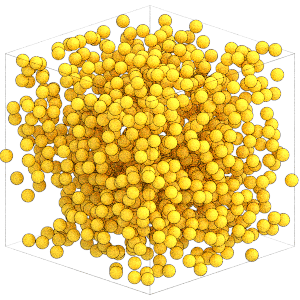

In [8]:
traj_log = gsd.hoomd.open('trajectory_prod.gsd', 'rb')

render_movie(traj_log)

In [9]:
thermo_log = gsd.hoomd.open('thermo_full.gsd', 'rb')

time = []
pe = []
for frame in thermo_log:
    time.append(frame.configuration.step)
    pe.append(frame.log['md/compute/ThermodynamicQuantities/potential_energy'][0])

n = thermo_log[-1].log['md/compute/ThermodynamicQuantities/num_particles'][0]
vol = thermo_log[-1].log['md/compute/ThermodynamicQuantities/volume'][0]

print("density: ", n/vol)

density:  0.30000000000000004


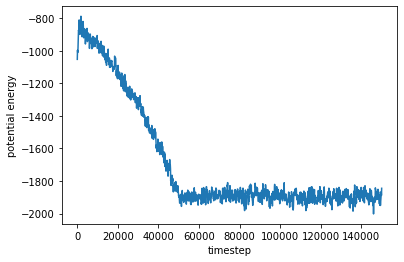

In [10]:
plt.plot(time, pe)
plt.ylabel('potential energy')
plt.xlabel('timestep')

plt.show()

In [11]:
traj = md.load('trajectory_prod.gsd')
r_traj_fluid, g_r_traj_fluid = md.compute_rdf(traj,  r_range=[0, traj.unitcell_lengths[0][1]/2.0], 
                                pairs = traj.top.select_pairs("all", "all"), 
                                  bin_width=0.05, periodic=True, opt=True)


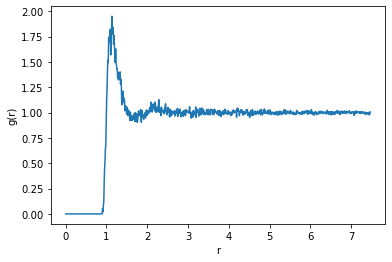

In [12]:
plt.plot(r_traj_fluid, g_r_traj_fluid)
plt.ylabel('g(r)')
plt.xlabel('r')

plt.show()

## Exercise 2: Simulation of a solid phase

Now, adjust the density to 1.4 and temperature to be 1.0 in the code and rerun the simulation. As you can see in the phase diagram (shown again below), this should be a solid crystalline phase for the LJ particles.  To avoid having to move around in the notebook, the same code is reproduced below. 
 * Render the simulation trajectory of the production step as movie. Does the phase look like a well ordered solid?
 * Calculate and plot the RDF. How does this compare the example plots above?  Would you conclude from both RDF and visual inspection that you have formed a solid phase? Why or why not?

In [26]:
from IPython.display import Image
Image(url='img/lj_phase_diagram.png')  

In [29]:
import hoomd
import gsd.hoomd

system_temperature = 1.0
final_rho = 0.5
compression_time = 20000
relax_time = 50000
production_time = 50000



cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=1)

#########################
# system initialization
#########################

sim.create_state_from_gsd(filename='datafiles/lj.gsd')
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=system_temperature)


#########################
# interaction definition
#########################

cell = hoomd.md.nlist.Cell(buffer=1.0)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('LJ', 'LJ')] = dict(epsilon=1, sigma=1)
lj.r_cut[('LJ', 'LJ')] = 2.5

#########################
# integrator setup
#########################


nvt = hoomd.md.methods.NVT(kT=system_temperature, filter=hoomd.filter.All(), tau=1.0)
integrator = hoomd.md.Integrator(dt=0.005)
integrator.forces.append(lj)
integrator.methods.append(nvt)
sim.operations.integrator = integrator

#########################
# runtime parameters
#########################

# add a logger to output the current step and timesteps per second (TPS) 
logger = hoomd.logging.Logger(categories=['scalar', 'string'])
logger.add(sim, quantities=['timestep', 'tps'])
table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=5000),
                          logger=logger)
sim.operations.writers.append(table)

# add a logger to output the thermodynamic data during the entire run 
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)

log_thermo_full = hoomd.logging.Logger()
log_thermo_full.add(thermodynamic_properties)
gsd_thermo_full = hoomd.write.GSD(filename='thermo_full.gsd',
                             trigger=hoomd.trigger.Periodic(100),
                             mode='wb',
                             filter=hoomd.filter.Null(),
                             log=log_thermo_full)
sim.operations.writers.append(gsd_thermo_full)


log_traj_full = hoomd.logging.Logger()
gsd_traj_full = hoomd.write.GSD(filename='trajectory_full.gsd',
                             trigger=hoomd.trigger.Periodic(5000),
                             mode='wb',
                             filter=hoomd.filter.All(),
                             log=log_traj_full)
sim.operations.writers.append(gsd_traj_full)

# ================
# compress the box
# ================


# ramp will define a switching factor for adjusting from the initial to the final box size
ramp = hoomd.variant.Ramp(A=0, B=1, t_start=sim.timestep, t_ramp=compression_time)

initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box
final_box.volume = sim.state.N_particles / final_rho
box_resize_trigger = hoomd.trigger.Periodic(10)
box_resize = hoomd.update.BoxResize(box1=initial_box,
                                    box2=final_box,
                                    variant=ramp,
                                    trigger=box_resize_trigger)
sim.operations.updaters.append(box_resize)
sim.run(compression_time+1)
if sim.state.box == final_box:
    print("system box size matches target")
    
sim.operations.updaters.remove(box_resize)
print("compression complete")

# ================
# relaxation
# ================

sim.run(relax_time)
print("relaxation complete")

# ================
# production 
# ================

log_thermo = hoomd.logging.Logger()
log_thermo.add(thermodynamic_properties)
gsd_thermo = hoomd.write.GSD(filename='thermo_prod.gsd',
                             trigger=hoomd.trigger.Periodic(100),
                             mode='wb',
                             filter=hoomd.filter.Null(),
                             log=log_thermo)
sim.operations.writers.append(gsd_thermo)

log_traj = hoomd.logging.Logger()
gsd_traj = hoomd.write.GSD(filename='trajectory_prod.gsd',
                             trigger=hoomd.trigger.Periodic(5000),
                             mode='wb',
                             filter=hoomd.filter.All(),
                             log=log_traj)
sim.operations.writers.append(gsd_traj)

sim.run(production_time)

hoomd.write.GSD.write(state=sim.state, filename='final.gsd', mode='wb')
print("simulation complete")

#delete the instances we defined ensure writers are closed
del sim, gsd_thermo, gsd_traj, thermodynamic_properties, log_thermo, log_traj
del log_thermo_full, gsd_thermo_full, logger, table, log_traj_full, gsd_traj_full
del integrator, nvt, lj, cell, cpu

Simulation.timestep  Simulation.tps 
       5000            3602.75305   
       10000           2993.75291   
       15000           2098.30193   
       20000           1598.23150   
system box size matches target
compression complete
       25000           859.46419    
       30000           856.62029    
       35000           848.59365    
       40000           856.14668    
       45000           861.21113    
       50000           865.09738    
       55000           867.67055    
       60000           869.85037    
       65000           872.40290    
       70000           873.51724    
relaxation complete
       75000           889.23682    
       80000           888.73220    
       85000           889.25924    
       90000           890.87066    
       95000           890.93381    
      100000           890.42107    
      105000           891.09368    
      110000           891.06498    
      115000           891.49064    
      120000           890.72793    
sim

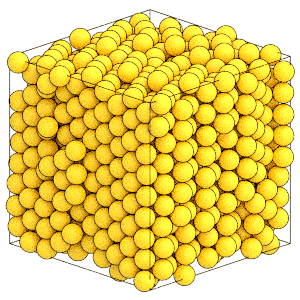

In [30]:
traj_log = gsd.hoomd.open('trajectory_prod.gsd', 'rb')

#render the last frame
render(traj_log[-1]])

In [31]:
traj = md.load('trajectory_prod.gsd')
r_traj_solid1, g_r_traj_solid1 = md.compute_rdf(traj,  r_range=[0, traj.unitcell_lengths[0][1]/2.0], 
                                pairs = traj.top.select_pairs("all", "all"), 
                                  bin_width=0.01, periodic=True, opt=True)



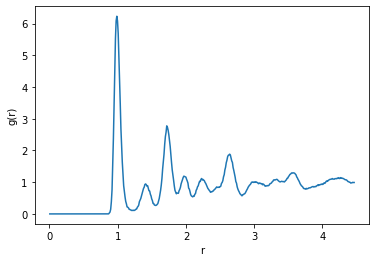

In [32]:
plt.plot(r_traj_solid1, g_r_traj_solid1)
plt.ylabel('g(r)')
plt.xlabel('r')

plt.show()

# Exercise 3: Equilibrating the system

Now, set the statepoint to be T = 0.25 and density = 1.4, and reduce and rerun the simulation in the code below.  Note, this code has the time for the compression and relaxation steps set to be 5000  and 20000 steps, respectively,  intentionally. 
* Calculate the RDF below; we will save the output into a new set of variables and plot this against the T=1.0 and density = 1.4 data from above. 
    * What differences do you observe?  While we would not necessarily expect these plots to be identical, if anything we would expect the lower temperature state to demonstrate more well defined ordering; clearly it is not. 
* Render the last frame of the trajectory.
    * How does this visually compare to the higher temperature state and what you'd expect a crystal to look like?
 
The differences are related to factors: we rapidly increased the rate of compression while simultaneously lowering the temperature.  This effectively has trapped the system in a metastable state that it has trouble escaping. 
 * Increase the time over which compression occurs and rerun the simulation.  At what value you see better agreement between the two RDFs? 
 * Take note of the mean and stdev of the PE for different values of compression time. How do they compare and do you see convergence as the time increases?

In [68]:
import hoomd
import gsd.hoomd

system_temperature = 1.0
final_rho = 0.5
compression_time = 5000
relax_time = 20000
production_time = 50000



cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=1)

#########################
# system initialization
#########################

sim.create_state_from_gsd(filename='datafiles/lj.gsd')
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=system_temperature)


#########################
# interaction definition
#########################

cell = hoomd.md.nlist.Cell(buffer=1.0)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('LJ', 'LJ')] = dict(epsilon=1, sigma=1)
lj.r_cut[('LJ', 'LJ')] = 2.5

#########################
# integrator setup
#########################


nvt = hoomd.md.methods.NVT(kT=system_temperature, filter=hoomd.filter.All(), tau=1.0)
integrator = hoomd.md.Integrator(dt=0.005)
integrator.forces.append(lj)
integrator.methods.append(nvt)
sim.operations.integrator = integrator

#########################
# runtime parameters
#########################

# add a logger to output the current step and timesteps per second (TPS) 
logger = hoomd.logging.Logger(categories=['scalar', 'string'])
logger.add(sim, quantities=['timestep', 'tps'])
table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=5000),
                          logger=logger)
sim.operations.writers.append(table)

# add a logger to output the thermodynamic data during the entire run 
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)

log_thermo_full = hoomd.logging.Logger()
log_thermo_full.add(thermodynamic_properties)
gsd_thermo_full = hoomd.write.GSD(filename='thermo_full.gsd',
                             trigger=hoomd.trigger.Periodic(100),
                             mode='wb',
                             filter=hoomd.filter.Null(),
                             log=log_thermo_full)
sim.operations.writers.append(gsd_thermo_full)


log_traj_full = hoomd.logging.Logger()
gsd_traj_full = hoomd.write.GSD(filename='trajectory_full.gsd',
                             trigger=hoomd.trigger.Periodic(5000),
                             mode='wb',
                             filter=hoomd.filter.All(),
                             log=log_traj_full)
sim.operations.writers.append(gsd_traj_full)

# ================
# compress the box
# ================


# ramp will define a switching factor for adjusting from the initial to the final box size
ramp = hoomd.variant.Ramp(A=0, B=1, t_start=sim.timestep, t_ramp=compression_time)

initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box
final_box.volume = sim.state.N_particles / final_rho
box_resize_trigger = hoomd.trigger.Periodic(10)
box_resize = hoomd.update.BoxResize(box1=initial_box,
                                    box2=final_box,
                                    variant=ramp,
                                    trigger=box_resize_trigger)
sim.operations.updaters.append(box_resize)
sim.run(compression_time+1)
if sim.state.box == final_box:
    print("system box size matches target")
    
sim.operations.updaters.remove(box_resize)
print("compression complete")

# ================
# relaxation
# ================

sim.run(relax_time)
print("relaxation complete")

# ================
# production 
# ================

log_thermo = hoomd.logging.Logger()
log_thermo.add(thermodynamic_properties)
gsd_thermo = hoomd.write.GSD(filename='thermo_prod.gsd',
                             trigger=hoomd.trigger.Periodic(100),
                             mode='wb',
                             filter=hoomd.filter.Null(),
                             log=log_thermo)
sim.operations.writers.append(gsd_thermo)

log_traj = hoomd.logging.Logger()
gsd_traj = hoomd.write.GSD(filename='trajectory_prod.gsd',
                             trigger=hoomd.trigger.Periodic(5000),
                             mode='wb',
                             filter=hoomd.filter.All(),
                             log=log_traj)
sim.operations.writers.append(gsd_traj)

sim.run(production_time)

hoomd.write.GSD.write(state=sim.state, filename='final.gsd', mode='wb')
print("simulation complete")

#delete the instances we defined ensure writers are closed
del sim, gsd_thermo, gsd_traj, thermodynamic_properties, log_thermo, log_traj
del log_thermo_full, gsd_thermo_full, logger, table, log_traj_full, gsd_traj_full
del integrator, nvt, lj, cell, cpu

Simulation.timestep  Simulation.tps 
       5000            2156.54935   
       10000           1981.72547   
       15000           1938.64203   
       20000           1911.50786   
       25000           1875.10224   
       30000           1846.30818   
       35000           1789.96054   
       40000           1706.80460   
       45000           1629.73201   
       50000           1525.84424   
system box size matches target
compression complete
       55000           893.50296    
       60000           895.57656    
       65000           896.11362    
       70000           895.68696    
relaxation complete
       75000           894.98037    
       80000           898.12449    
       85000           895.84652    
       90000           895.05853    
       95000           894.16439    
      100000           893.29159    
      105000           892.19990    
      110000           891.67007    
      115000           890.24557    
      120000           888.46715    
sim

In [69]:
traj = md.load('trajectory_prod.gsd')
r_traj_solid2, g_r_traj_solid2 = md.compute_rdf(traj,  r_range=[0, traj.unitcell_lengths[0][1]/2.0], 
                                pairs = traj.top.select_pairs("all", "all"), 
                                  bin_width=0.01, periodic=True, opt=True)




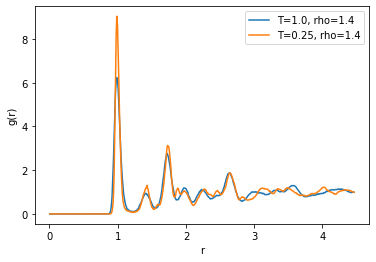

In [70]:
plt.plot(r_traj_solid1, g_r_traj_solid1, label='T=1.0, rho=1.4')
plt.plot(r_traj_solid2, g_r_traj_solid2, label='T=0.25, rho=1.4')


plt.ylabel('g(r)')
plt.xlabel('r')
plt.legend()
plt.show()

In [71]:
thermo_log = gsd.hoomd.open('thermo_prod.gsd', 'rb')
import numpy as np
time = []
pe = []
for frame in thermo_log:
    time.append(frame.configuration.step)
    pe.append(frame.log['md/compute/ThermodynamicQuantities/potential_energy'][0])

print('mean pe: ', np.mean(np.array(pe)), ' stdev: ', np.std(np.array(pe)))

mean pe:  -2745.5579103022264  stdev:  142.5281162222082


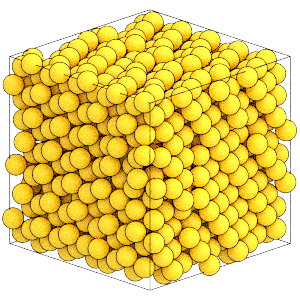

In [72]:
traj_log = gsd.hoomd.open('trajectory_prod.gsd', 'rb')

render(traj_log[-1])